In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pqr 

import src.ts as ts

In [64]:
df = pd.read_json("./data/task1/VFINX.json")
df["VFINX"] = df["Close"] + df["Dividends"].cumsum().shift().fillna(0)

rf = pd.read_csv("./data/rf.csv", 
                 index_col="Date", 
                 parse_dates=True,).loc[:, "Price"]
rf = (1 + rf) ** (1 / 360) - 1

df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,VIX_Close,VFINX
1986-01-02,9.969467,9.969467,9.969467,9.969467,0,0.0,0,18.07,9.969467
1986-01-03,10.035052,10.035052,10.035052,10.035052,0,0.0,0,17.96,10.035052
1986-01-06,10.030688,10.030688,10.030688,10.030688,0,0.0,0,17.05,10.030688
1986-01-07,10.179354,10.179354,10.179354,10.179354,0,0.0,0,17.39,10.179354
1986-01-08,9.899508,9.899508,9.899508,9.899508,0,0.0,0,19.97,9.899508


# Задание

Построить торговлю индексом `VFINX`, удовлетворяющую условиям: 
$$SR \rightarrow max,  \\ s.t.SR \ge 0.6, CAGR \sim 10.9\%$$

# EDA

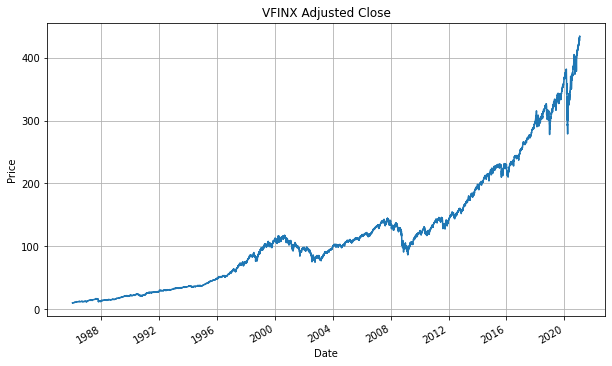

In [65]:
df["VFINX"].plot(
    figsize=(10, 6), 
    title="VFINX Adjusted Close", 
    xlabel="Date",
    ylabel="Price",
    grid=True,
);

Видно, что из-за большого периода плохо различима динамика индекса в первые годы. Визуально кажется, что в последнее время волатильность сильно возросла, хотя это не совсем так.

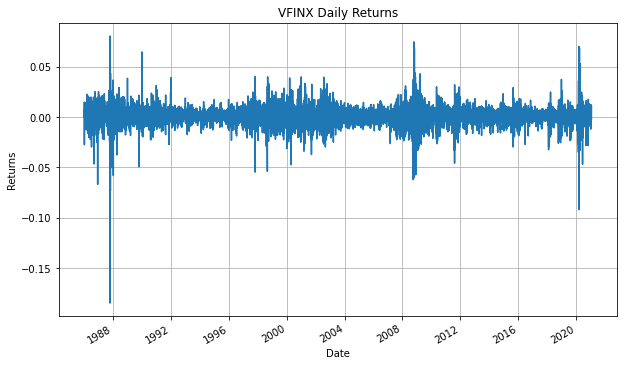

In [66]:
df["VFINX"].pct_change().plot(
    figsize=(10, 6), 
    title="VFINX Daily Returns", 
    xlabel="Date",
    ylabel="Returns",
    grid=True,
);

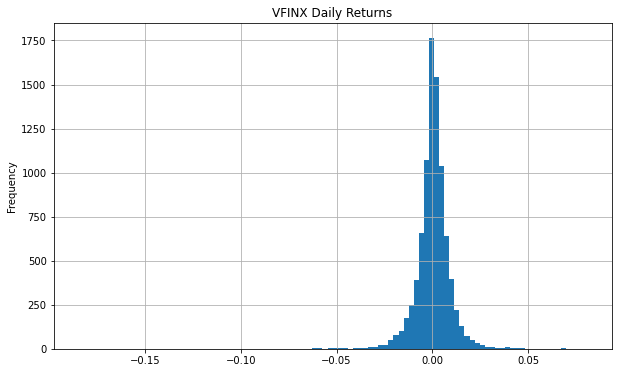

In [67]:
df["VFINX"].pct_change().plot.hist(
    bins=100,
    figsize=(10, 6), 
    title="VFINX Daily Returns", 
    grid=True,
);

Дневная доходность колеблется в районе +/-2-3%, но наблюдаются и периоды, когда доходность резко выстреливает как вниз так и вверх. При этом по модулю наибольший спайк - вниз в 1980-е годы. 

Распределение доходности в целом похоже на нормальное со средним в нуле, но наблюдаются "тяжелые хвосты", причем левый хвост (отрицательная доходность) "тяжелее" правого.

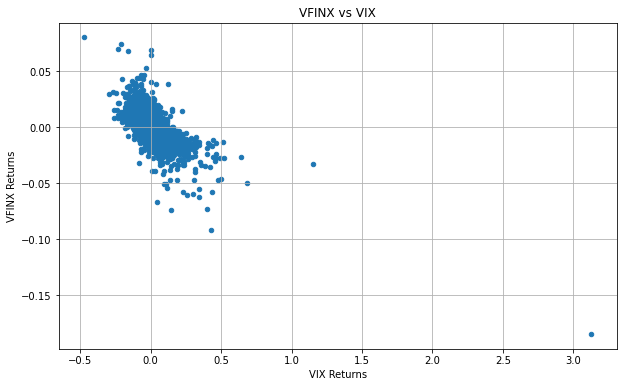

In [68]:
df[["VFINX", "VIX_Close"]].pct_change().plot.scatter(
    x="VIX_Close",
    y="VFINX",
    title="VFINX vs VIX",
    xlabel="VIX Returns",
    ylabel="VFINX Returns",
    grid=True,
    figsize=(10, 6),
);

Заметно, что есть отрицательная взаимосвязь между доходностью `VFINX` и процентными изменениями индекса `VIX`. Что неудивительно, т.к. `VIX` по сути показывает волатильность индекса, а рост волатильности обычно происходит в периоды шоков на рынке.

# Скейлинг относительно VIX

Попробуем предсказывать значения `VIX` и инвестировать с весом:
$$w = \frac{VIX_{target}}{VIX_{forecast}}$$

Таргет по `VIX` в идеале надо выбирать на основе какого-то фундаментального исследования, но в задании запрещено пользоваться другими данными, поэтому просто переберем варианты. Хотя на практике считается, что значения `VIX` больше 20 уже говорят о повышенной волатильности.

Предсказание `VIX` можно тоже делать на основе фундаментальных данных, но для простоты будем брать скользящее среднее с периодом $n$, значения для которого тоже просто переберем.

In [69]:
grid_sharpe_vix = ts.grid_search(
    targets=[1, 2, 3, 5, 7, 10, 20, 30, 40, 50, 60, 100],
    ns=[3, 5, 7, 9, 11, 13, 17, 20, 33, 60],
    volatility=pqr.utils.partial(
        ts.vix_scaling,
        vix=df["VIX_Close"],
    ),
    df=df,
    metric=pqr.utils.partial(
        pqr.metrics.sharpe_ratio,
        annualizer=252,
        rf=rf,
    )
)

grid_cagr_vix = ts.grid_search(
    targets=[1, 2, 3, 5, 7, 10, 20, 30, 40, 50, 60, 100],
    ns=[3, 5, 7, 9, 11, 13, 17, 20, 33, 60],
    volatility=pqr.utils.partial(
        ts.vix_scaling,
        vix=df["VIX_Close"],
    ),
    df=df,
    metric=pqr.utils.partial(
        pqr.metrics.cagr,
        annualizer=252,
    )
)

In [70]:
grid_sharpe_vix.style.background_gradient(cmap="Greens").format(precision=2)

target,1,2,3,5,7,10,20,30,40,50,60,100
n,,,,,,,,,,,,
3,0.04,0.04,0.04,0.10,0.25,0.43,0.60,0.60,0.60,0.59,0.58,0.58
5,0.05,0.05,0.05,0.11,0.26,0.44,0.62,0.61,0.60,0.60,0.59,0.59
7,0.05,0.05,0.05,0.11,0.26,0.45,0.62,0.61,0.60,0.59,0.58,0.59
9,0.05,0.05,0.05,0.11,0.27,0.45,0.62,0.60,0.60,0.59,0.58,0.59
11,0.05,0.05,0.05,0.11,0.27,0.45,0.61,0.60,0.60,0.59,0.58,0.59
13,0.05,0.05,0.05,0.11,0.27,0.45,0.61,0.60,0.60,0.59,0.59,0.59
17,0.05,0.05,0.05,0.11,0.27,0.44,0.59,0.59,0.59,0.59,0.59,0.59
20,0.05,0.05,0.05,0.11,0.26,0.43,0.58,0.59,0.59,0.59,0.59,0.59
33,0.04,0.04,0.04,0.10,0.25,0.41,0.55,0.57,0.58,0.58,0.58,0.58


In [71]:
(grid_cagr_vix * 100).style.background_gradient(cmap="Greens").format(precision=2)

target,1,2,3,5,7,10,20,30,40,50,60,100
n,,,,,,,,,,,,
3,3.49,3.49,3.49,3.75,4.57,6.14,10.01,10.97,11.28,11.28,11.26,11.32
5,3.52,3.52,3.52,3.77,4.61,6.22,10.22,11.15,11.39,11.42,11.38,11.41
7,3.52,3.52,3.52,3.77,4.63,6.27,10.29,11.15,11.36,11.36,11.31,11.40
9,3.51,3.51,3.51,3.77,4.65,6.31,10.31,11.12,11.33,11.33,11.30,11.39
11,3.51,3.51,3.51,3.77,4.66,6.32,10.27,11.08,11.32,11.31,11.31,11.39
13,3.52,3.52,3.52,3.79,4.66,6.32,10.24,11.10,11.34,11.35,11.40,11.43
17,3.52,3.52,3.52,3.79,4.65,6.27,10.09,11.04,11.30,11.35,11.42,11.41
20,3.51,3.51,3.51,3.77,4.62,6.21,9.98,11.01,11.28,11.35,11.40,11.39
33,3.47,3.47,3.47,3.74,4.56,6.08,9.68,10.83,11.20,11.25,11.23,11.24


In [7]:
benchmark = pqr.Benchmark.from_index(
    index=df["VFINX"], 
    name="Buy and Hold",
)

table = pqr.metrics.Table()
table.add_metric(
    metric=pqr.utils.partial(
        pqr.metrics.sharpe_ratio,
        annualizer=252,
        rf=rf / 252,
    ),
    name="Sharpe Ratio",
)
table.add_metric(
    metric=pqr.utils.partial(
        pqr.metrics.cagr,
        annualizer=252,
    ),
    multiplier=100,
    name="CAGR, %",
)

fig = pqr.metrics.Figure(
    metric=pqr.metrics.compounded_returns,
    name="Compounded Returns (log scale)",
    benchmark=benchmark,
    log_scale=True,
    kwargs={
        "figsize": (10, 6),
    },
)

summary = pqr.metrics.Dashboard([table, fig])